# Imports

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Fraud Detection
<a href=https://www.kaggle.com/datasets/sanskar457/fraud-transaction-detection>Link to original Kaggle Dataset</a>
<br>
<a href=https://www.kaggle.com/code/retr00h/fraudulent-transactions-100-test-precision/notebook>Notebook link from where I took great Insights.</a>

# Configuring Kaggle API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
# Copying kaggle api key to working directory
cp drive/MyDrive/Colab\ Notebooks/kaggle.json .
# Then move kaggle.json into the folder where the API expects to find it.
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# downloading dataset
kaggle datasets download -d sanskar457/fraud-transaction-detection
# unzip dataset
unzip fraud-transaction-detection


Archive:  fraud-transaction-detection.zip
  inflating: Final Transactions.csv  


100%|██████████| 34.0M/34.0M [00:01<00:00, 24.8MB/s]


In [ ]:
import pandas as pd
from datetime import datetime
from time import mktime

def datetime_to_unix_time(dt):
    dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
    return mktime(dt.timetuple()) / 1000000000


transactions = pd.read_csv('Final Transactions.csv')
print(transactions.info(), '\n')
print(transactions.isna().sum(), '\n')
print('Prevalence: %2.4f' % (len(transactions[transactions['TX_FRAUD'] == 1]) / len(transactions['TX_FRAUD'])))

transactions = transactions.drop(['Unnamed: 0', 'TRANSACTION_ID', 'TX_FRAUD_SCENARIO'], axis = 'columns')
transactions.TX_DATETIME = transactions['TX_DATETIME'].apply(datetime_to_unix_time)
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB
None 

Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64 

Prevalence: 0.1345


,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
0,1.672531,596,3156,533.07,31,0,0
1,1.672531,4961,3412,808.56,130,0,0
2,1.672532,2,1365,1442.94,476,0,1
3,1.672532,4128,8737,620.65,569,0,0
4,1.672532,927,9906,490.66,634,0,0


In [35]:
# setting matplolib figure properties
mpl.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [16, 9]

### The dataset is highly unbalanced. We will have to deal with this later.

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

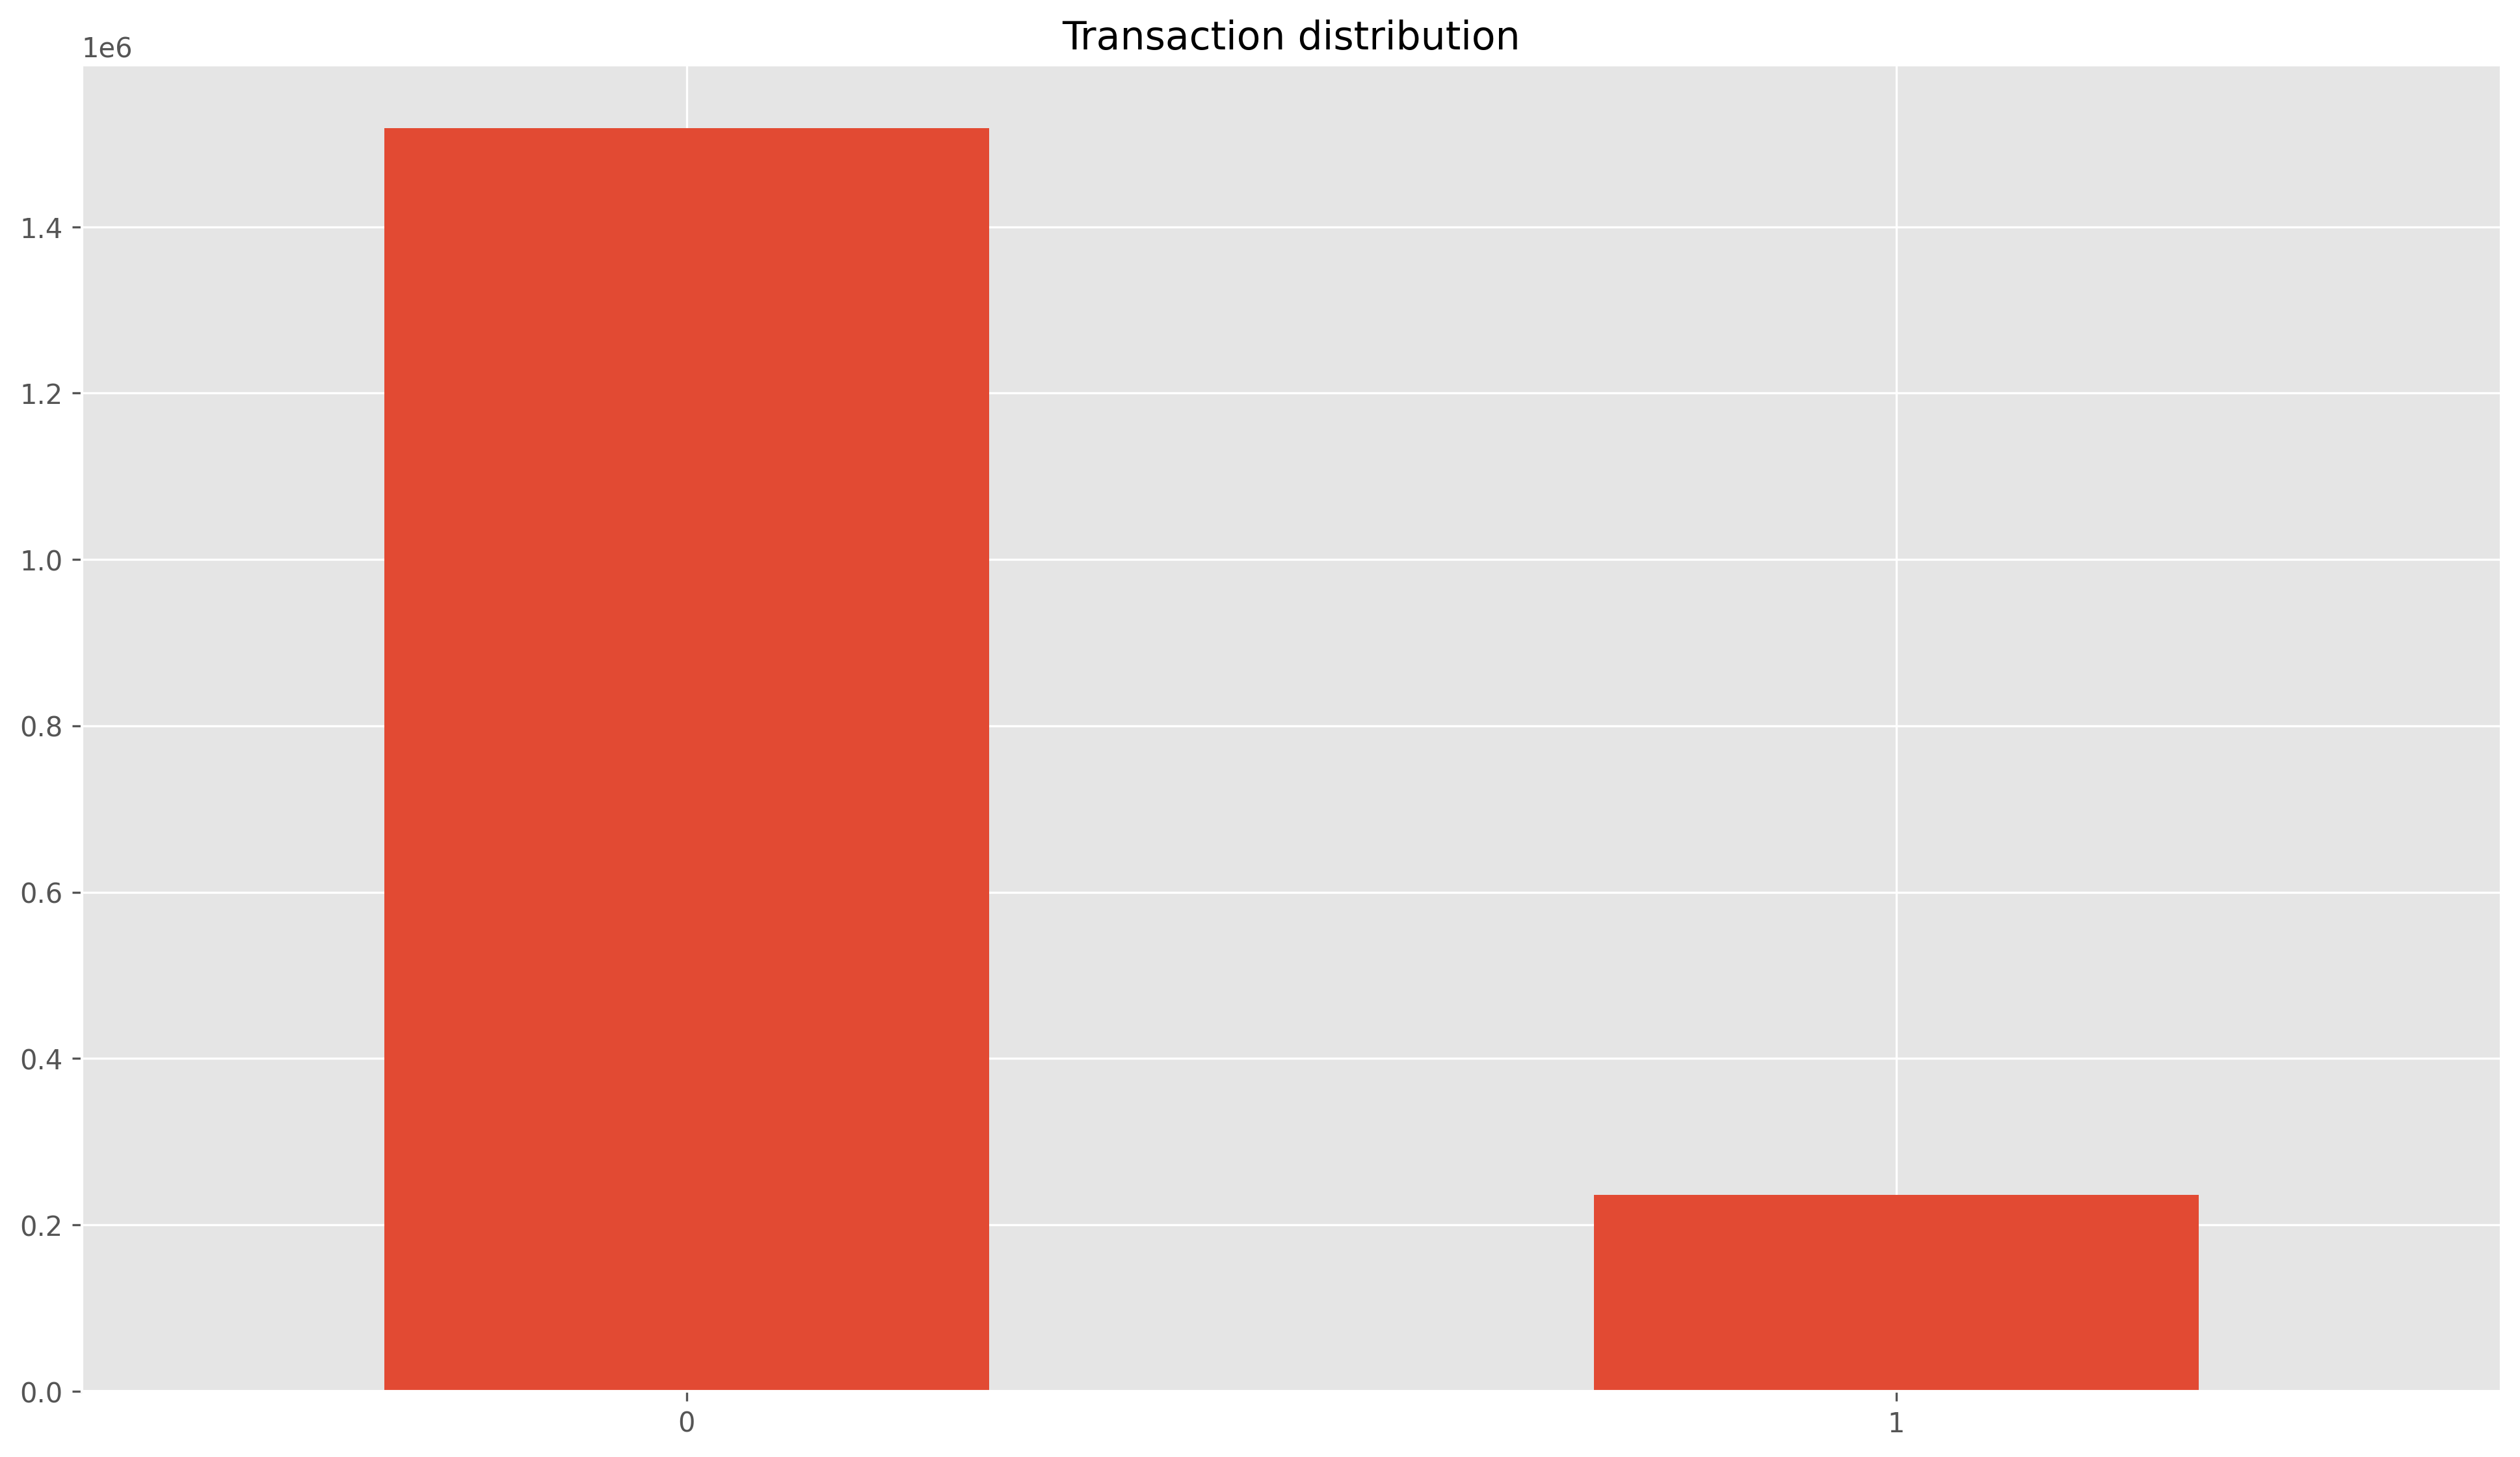

In [ ]:
transactions['TX_FRAUD'].value_counts().plot(kind = "bar", title = "Transaction distribution")
plt.xticks(rotation = 0)

### Analysing Feature importances.
Information gain or Mutual info is going to be used to evaluate how each of the variables explain the target variable.

Text(0.5, 1.0, 'Mutual Information Scores')

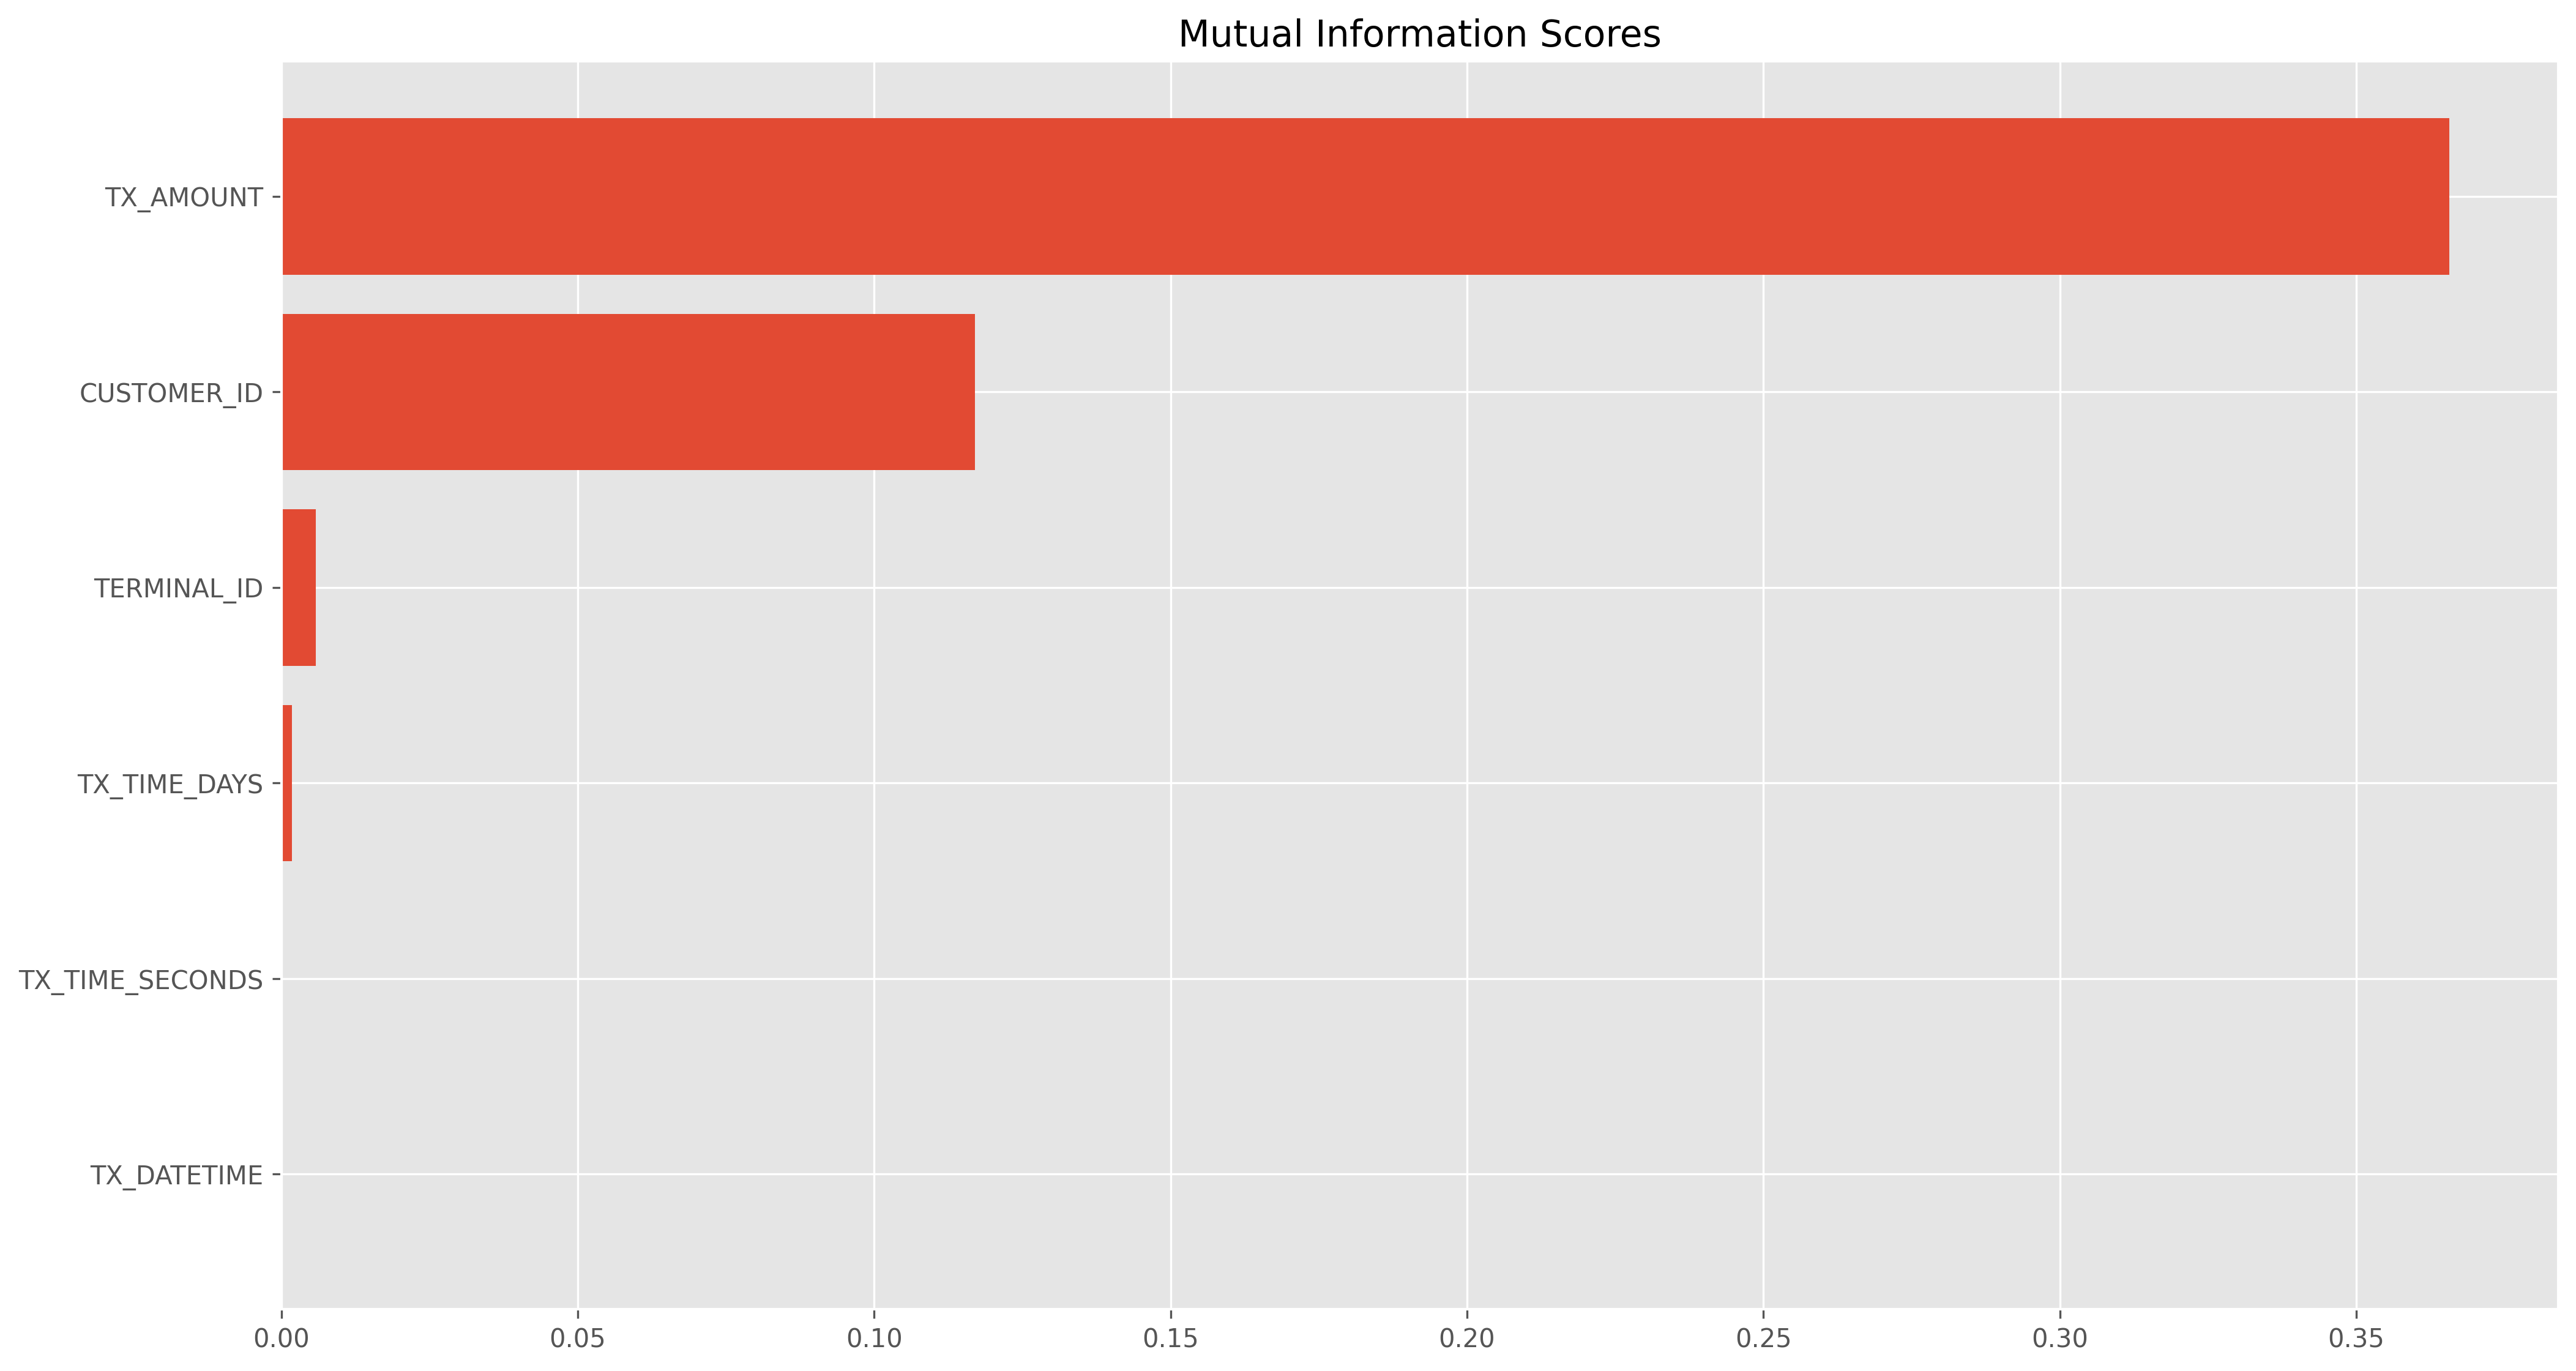

In [ ]:
mi_scores = mutual_info_classif(transactions.drop(['TX_FRAUD'], axis = 1), transactions['TX_FRAUD'], random_state = 0)
mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = transactions.drop('TX_FRAUD', axis = 1).columns)

mi_scores = mi_scores.sort_values(ascending = True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

# Analyzing Correlation between variables

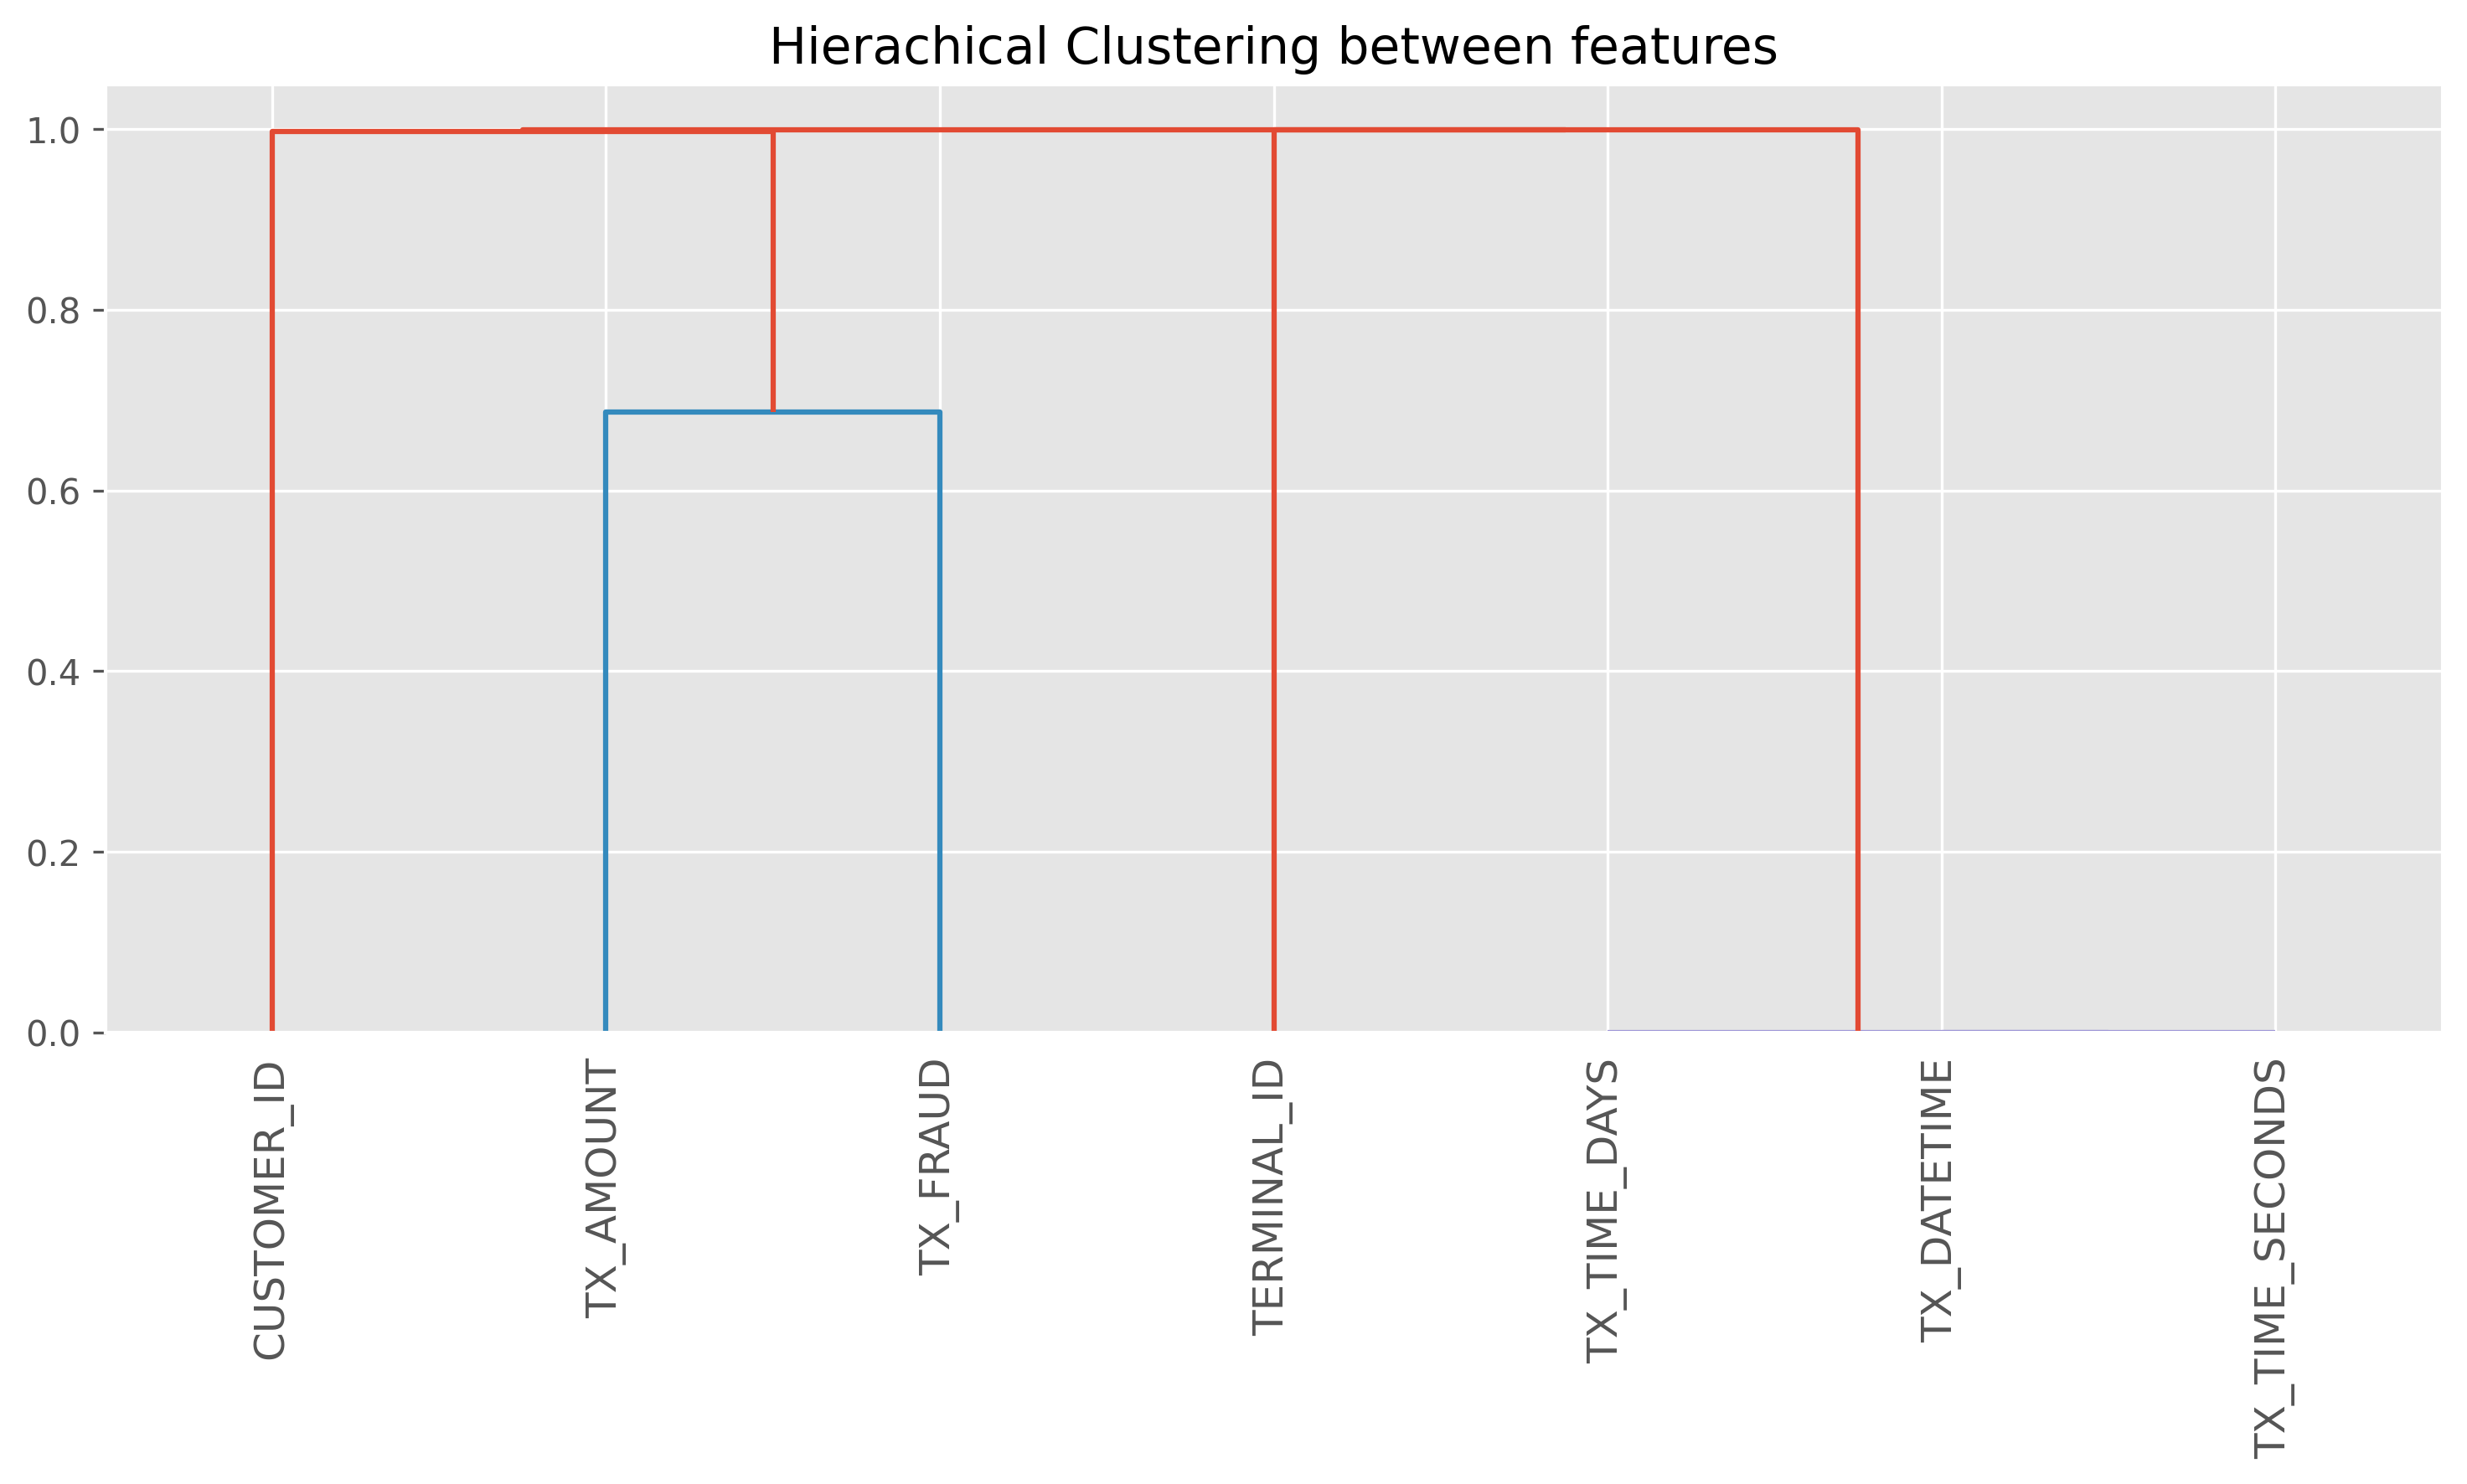

In [ ]:
correlations = transactions.corr()
plt.figure(figsize=(12,5))
plt.title('Hierachical Clustering between features')
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=transactions.columns, orientation='top', 
           leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.7
labels = fcluster(Z, threshold, criterion='distance')
# Show the cluster
labels

array([3, 2, 4, 1, 3, 3, 1], dtype=int32)

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(transactions.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(transactions[i])
    else:
        df_to_append = pd.DataFrame(transactions[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

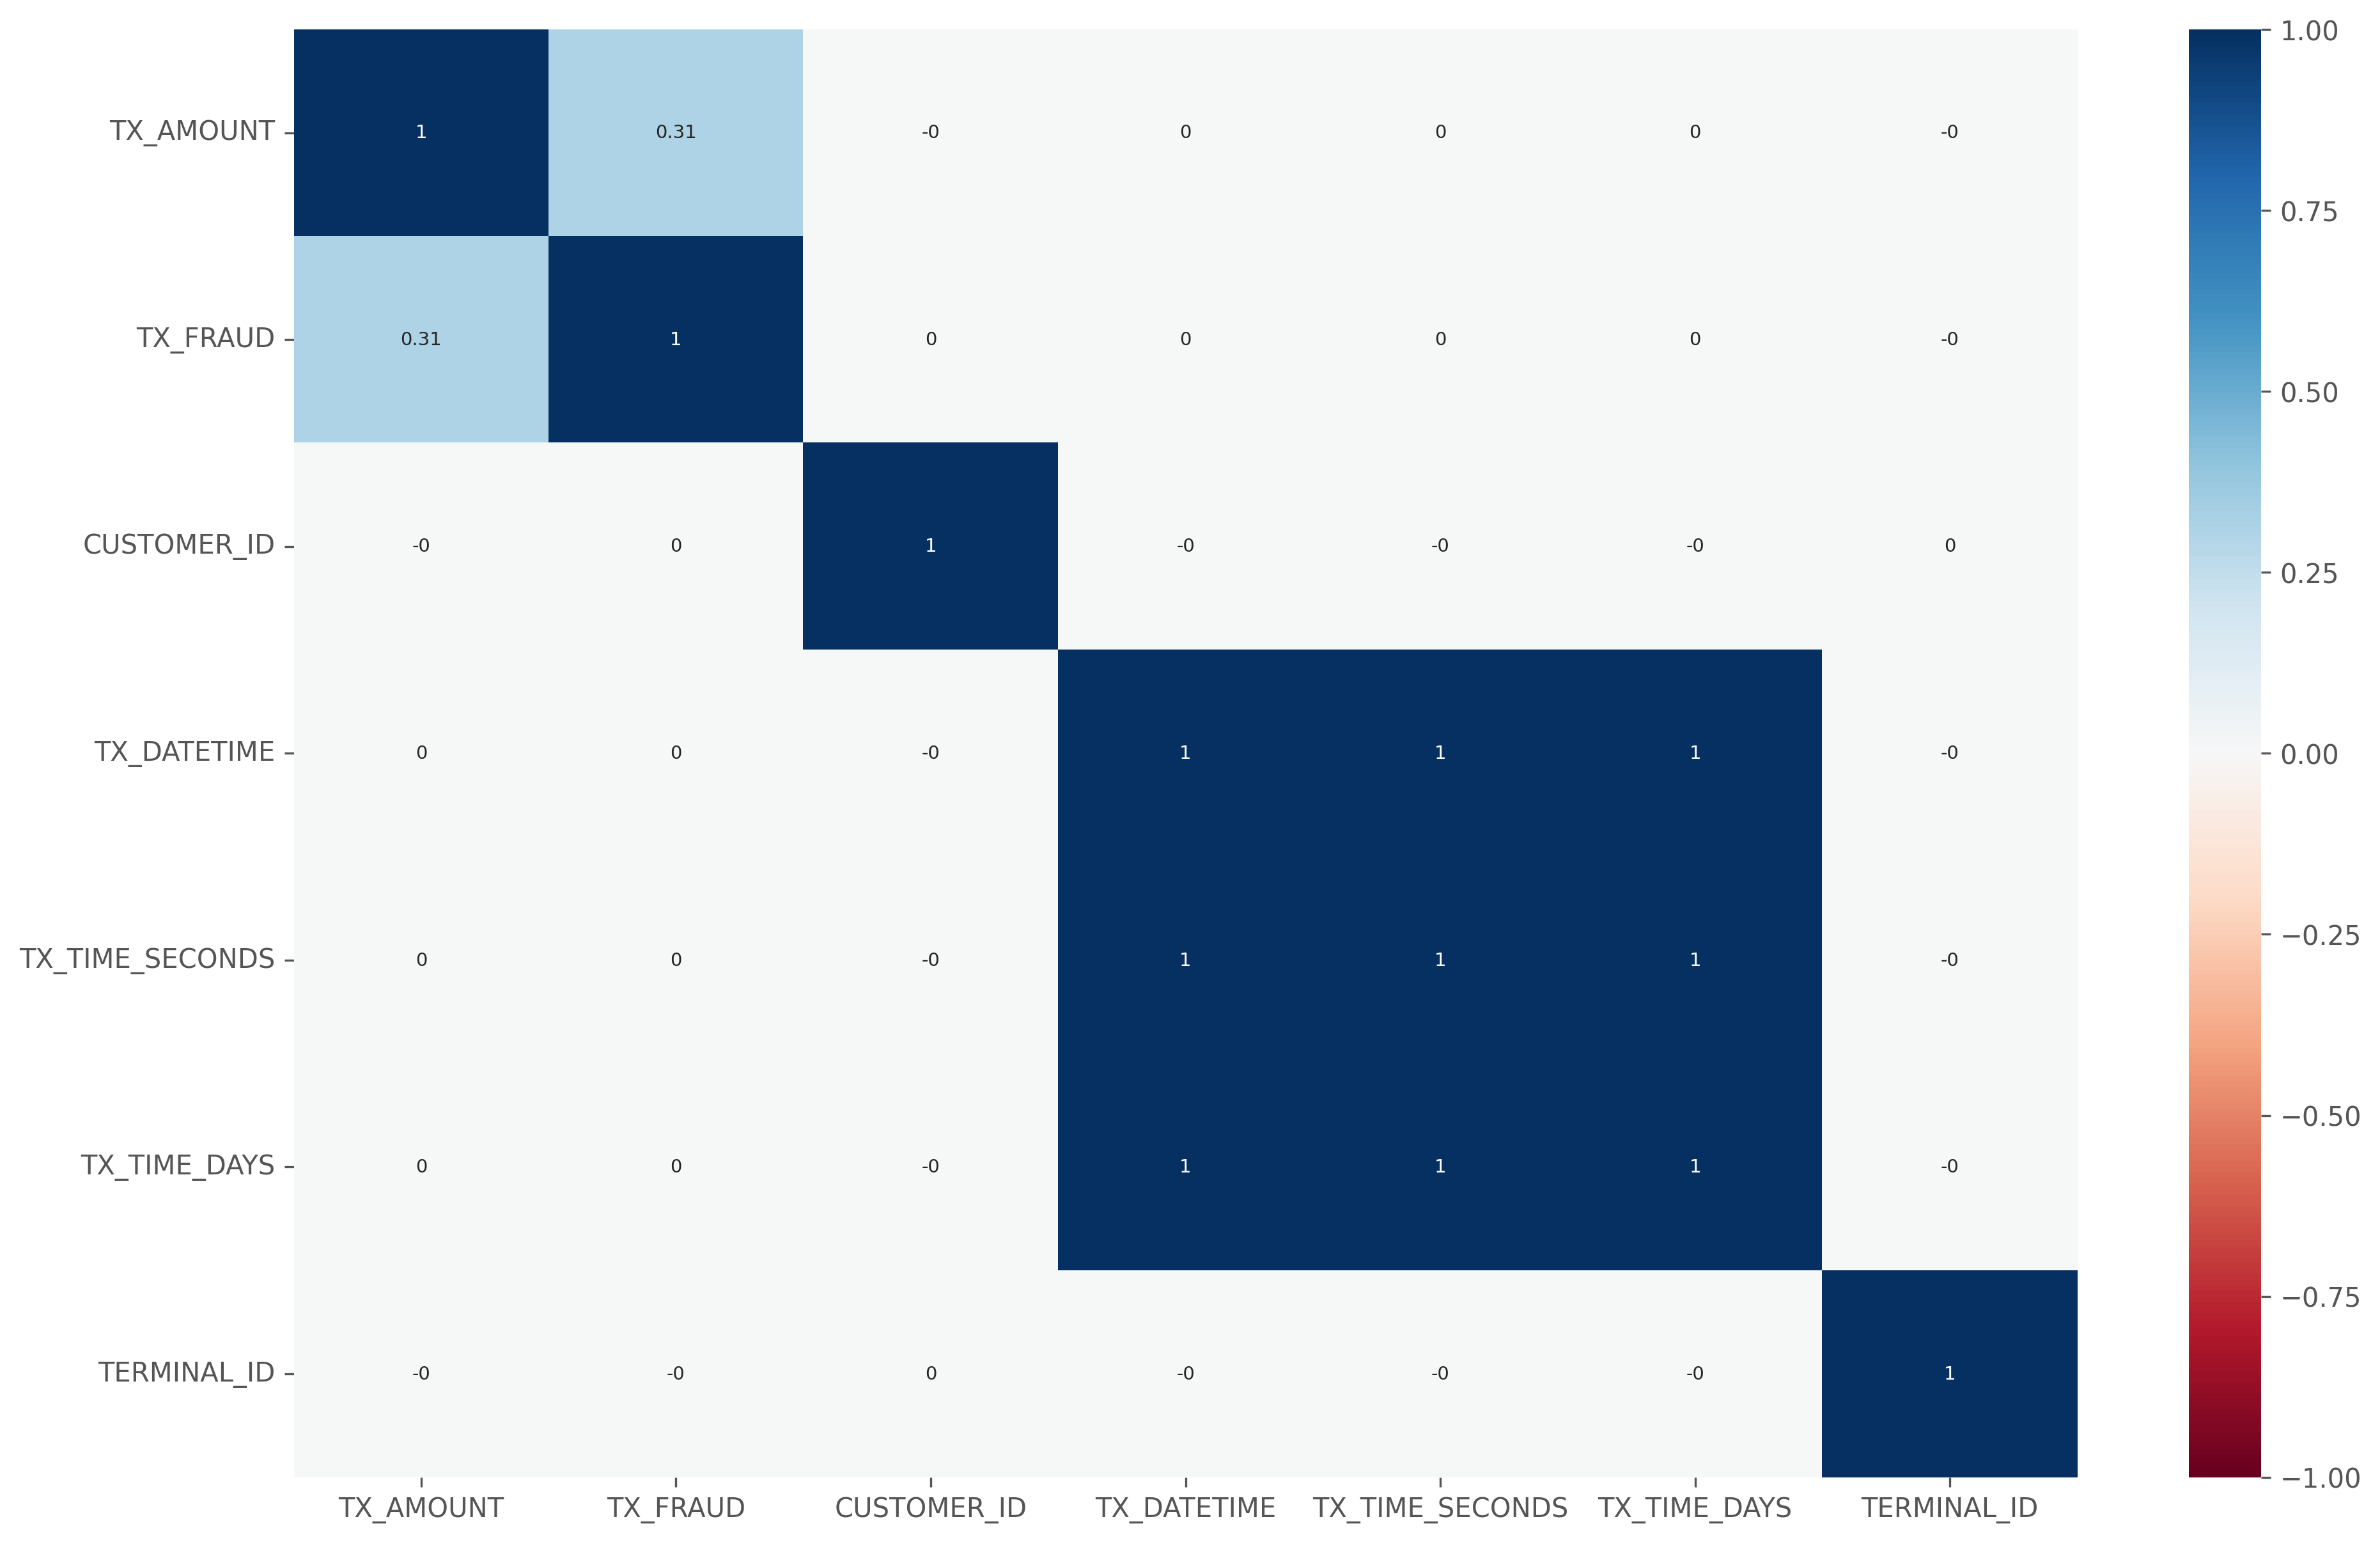

In [ ]:
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

# Applying oversampling techniques + train-test splitting
Using only 20% of the data since there are 1.7M transactions. Using stratify to garantee that the same amount of fraudlent transactions will be available in the test data.
<a href=https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/>SMOTE(Syntetic Minority Oversampling TEcnhique)</a> was used to balance the dataset.

In [26]:
transactions.columns

Index(['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT',
       'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD'],
      dtype='object')

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

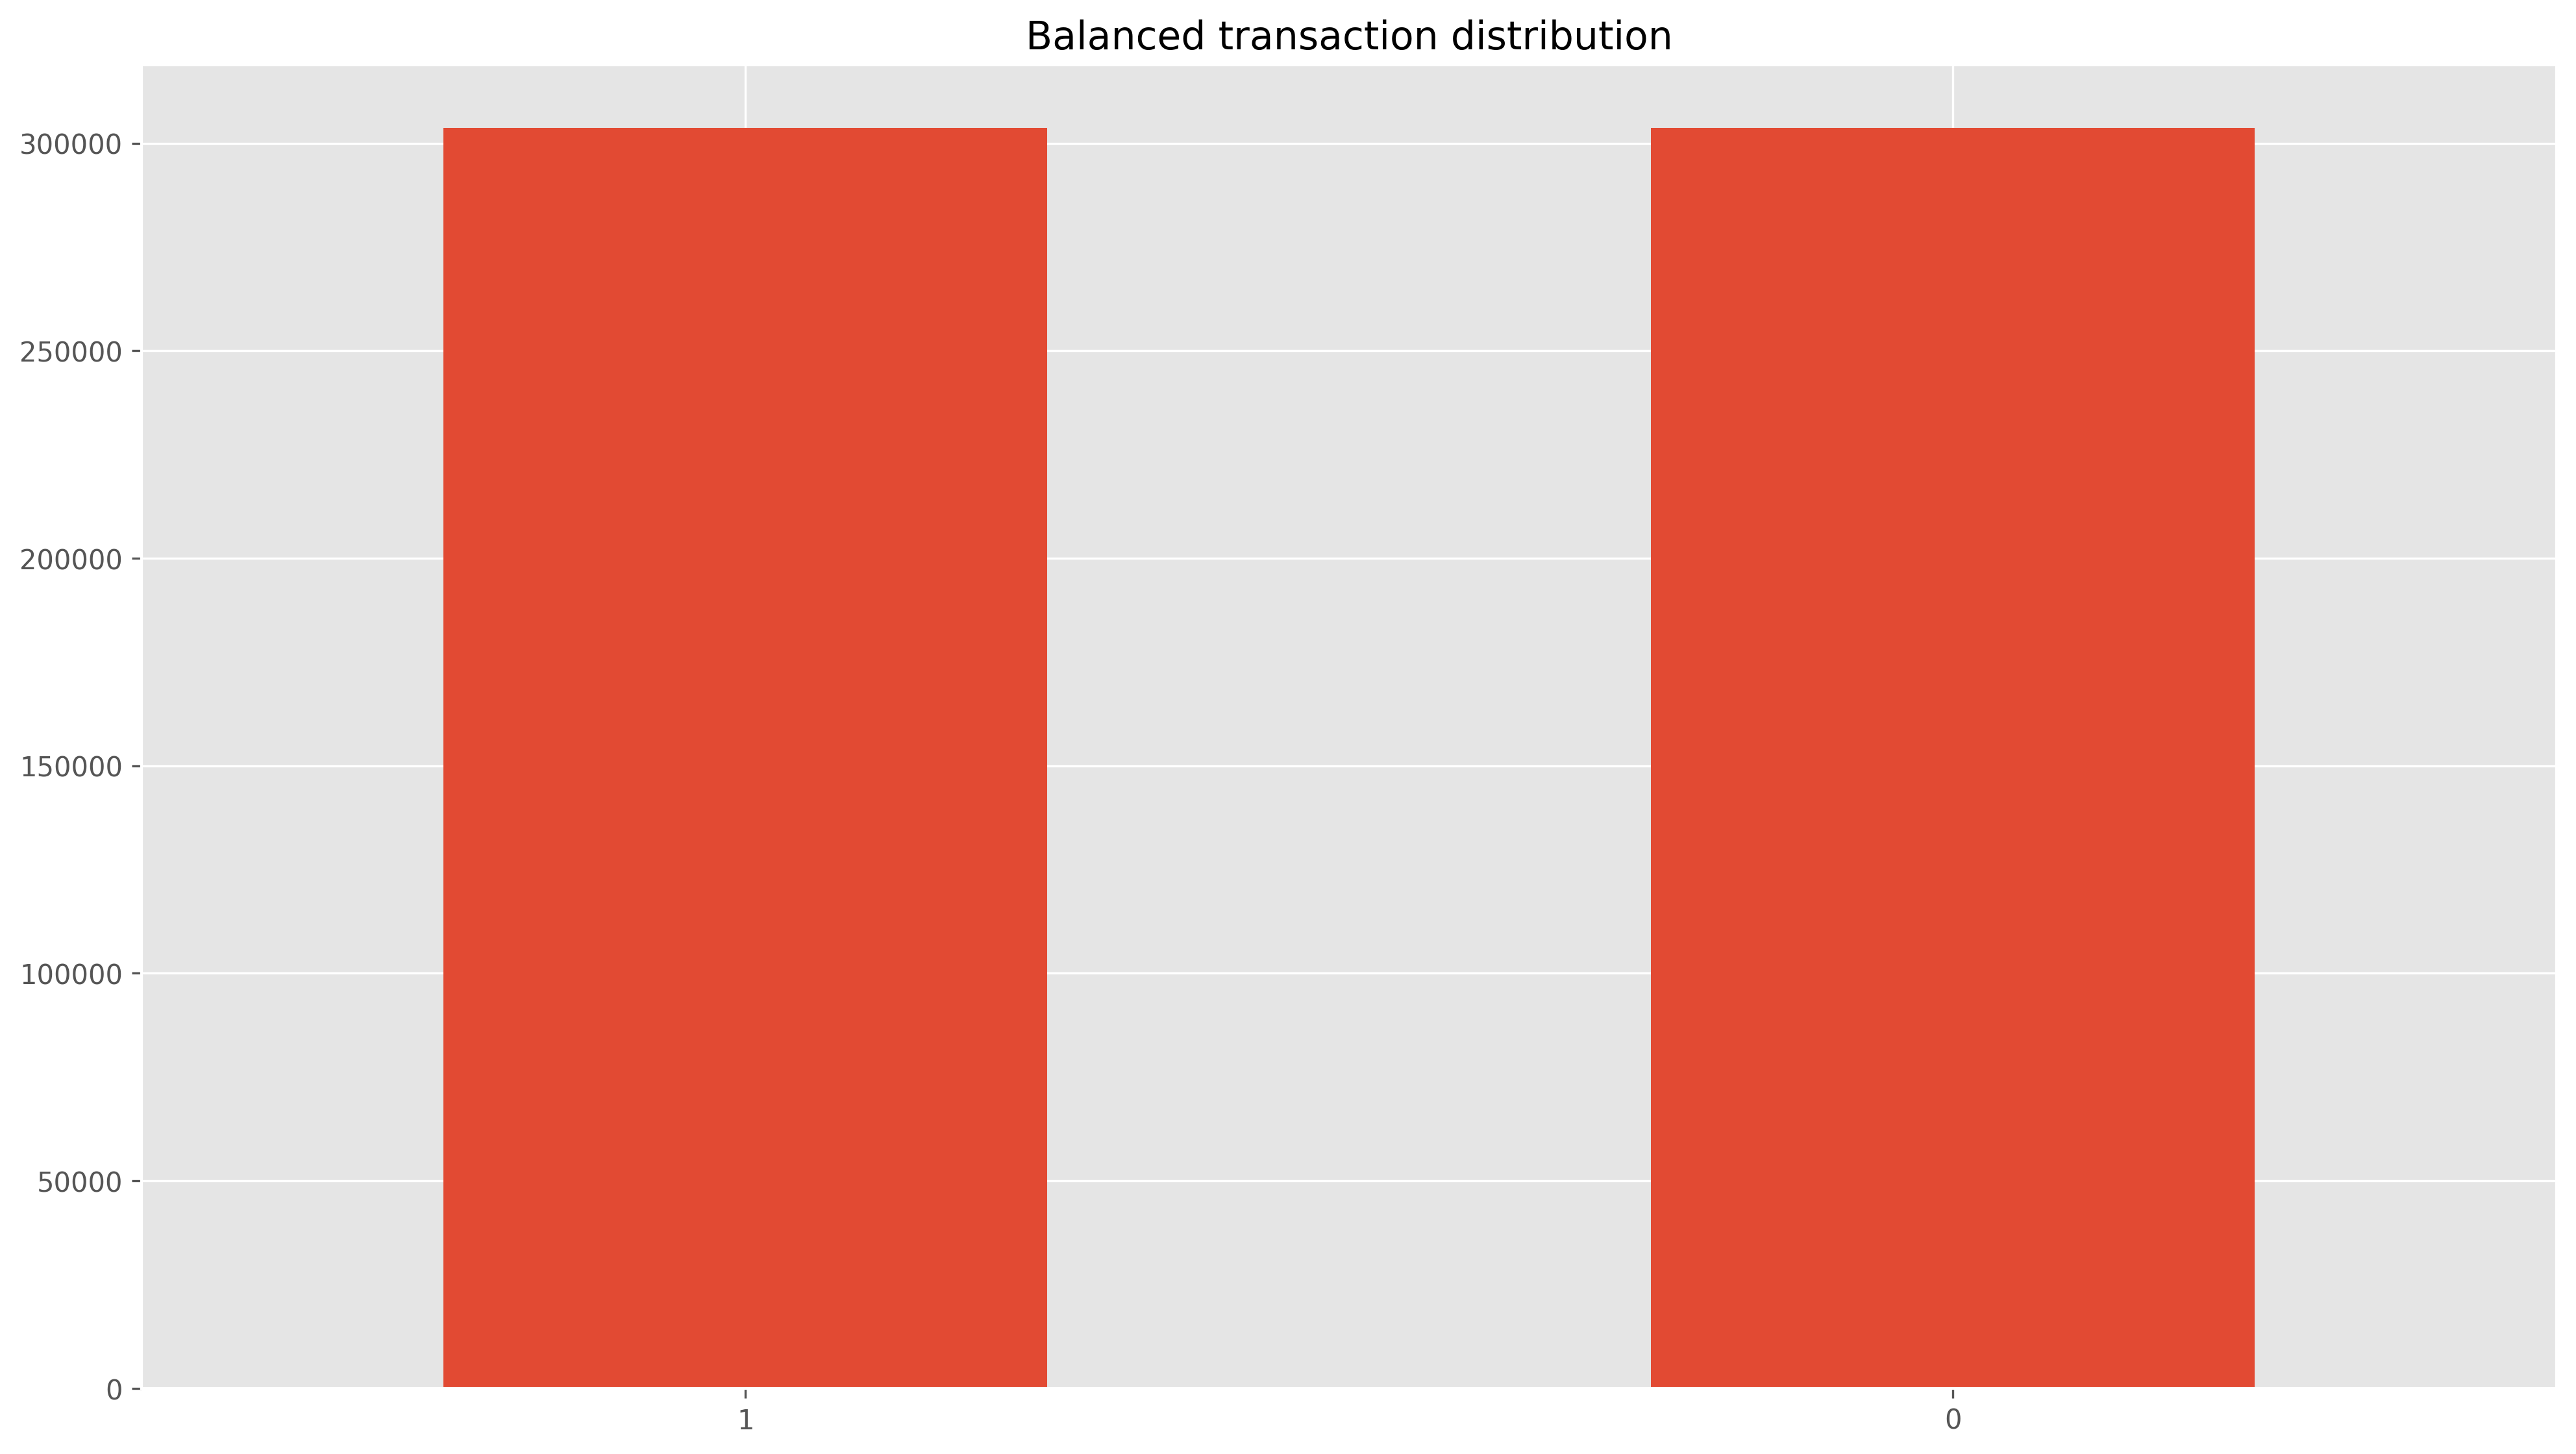

In [36]:
X_train, X_test, y_train, y_test = train_test_split(transactions['TX_AMOUNT'], transactions['TX_FRAUD'], test_size = 0.8, random_state = 0, stratify=transactions['TX_FRAUD']) # Using only 20% for train

oversampler = SMOTE(random_state = 0)
X_resampled, y_resampled = oversampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

y_resampled.value_counts().plot(kind = "bar", title = "Balanced transaction distribution")
plt.xticks(rotation = 0)

## Scaling features

In [38]:
scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = scaler.transform(X_resampled)

X_test = scaler.transform(X_test.to_numpy().reshape(-1, 1))

# Model Building

### Adaboost

In [40]:
ada = AdaBoostClassifier(random_state = 0, n_estimators=800, learning_rate=1.0)
ada.fit(X_resampled, y_resampled)

AdaBoostClassifier(n_estimators=800, random_state=0)

In [ ]:
ada_scores = cross_validate(AdaBoostClassifier(random_state = 0,
                                               n_estimators = 80,
                                               learning_rate = 1.0),
                            X_resampled, y_resampled, cv = 5, scoring = ('accuracy','precision', 'recall', 'roc_auc'))


In [50]:
print("Mean accuracy: %2.2f" % (np.mean(ada_scores['test_accuracy']) * 100))
print("Mean roc_auc: %2.2f" % (np.mean(ada_scores['test_roc_auc']) * 100))
print("Mean precision: %2.2f" % (np.mean(ada_scores['test_precision']) * 100))
print("Mean recall: %2.2f" % (np.mean(ada_scores['test_recall']) * 100))

Mean accuracy: 98.23
Mean roc_auc: 98.46
Mean precision: 100.00
Mean recall: 96.45


### Random Forest

In [47]:
rf = RandomForestClassifier(n_estimators=150, min_samples_leaf=76, max_depth=5)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5, min_samples_leaf=76, n_estimators=150)

In [49]:
rf_scores = cross_validate(RandomForestClassifier(n_estimators=150, min_samples_leaf=76, max_depth=5),
                            X_resampled, y_resampled, cv = 5, scoring = ('accuracy','precision', 'recall', 'roc_auc'))


In [53]:
print("Mean accuracy: %2.2f" % (np.mean(rf_scores['test_accuracy']) * 100))
print("Mean roc_auc: %2.2f" % (np.mean(rf_scores['test_roc_auc']) * 100))
print("Mean precision: %2.2f" % (np.mean(rf_scores['test_precision']) * 100))
print("Mean recall: %2.2f" % (np.mean(rf_scores['test_recall']) * 100))

Mean accuracy: 98.23
Mean roc_auc: 98.48
Mean precision: 100.00
Mean recall: 96.45


# Performing predictions on the test set

In [ ]:
rf_preds = rf.predict(X_test)
ada_preds = ada.predict(X_test)

In [57]:
rf_auc = roc_auc_score(y_test, rf_preds)
ada_auc = roc_auc_score(y_test, ada_preds)

In [60]:
rf_auc, ada_auc

(0.9826433584955635, 0.9826433584955635)

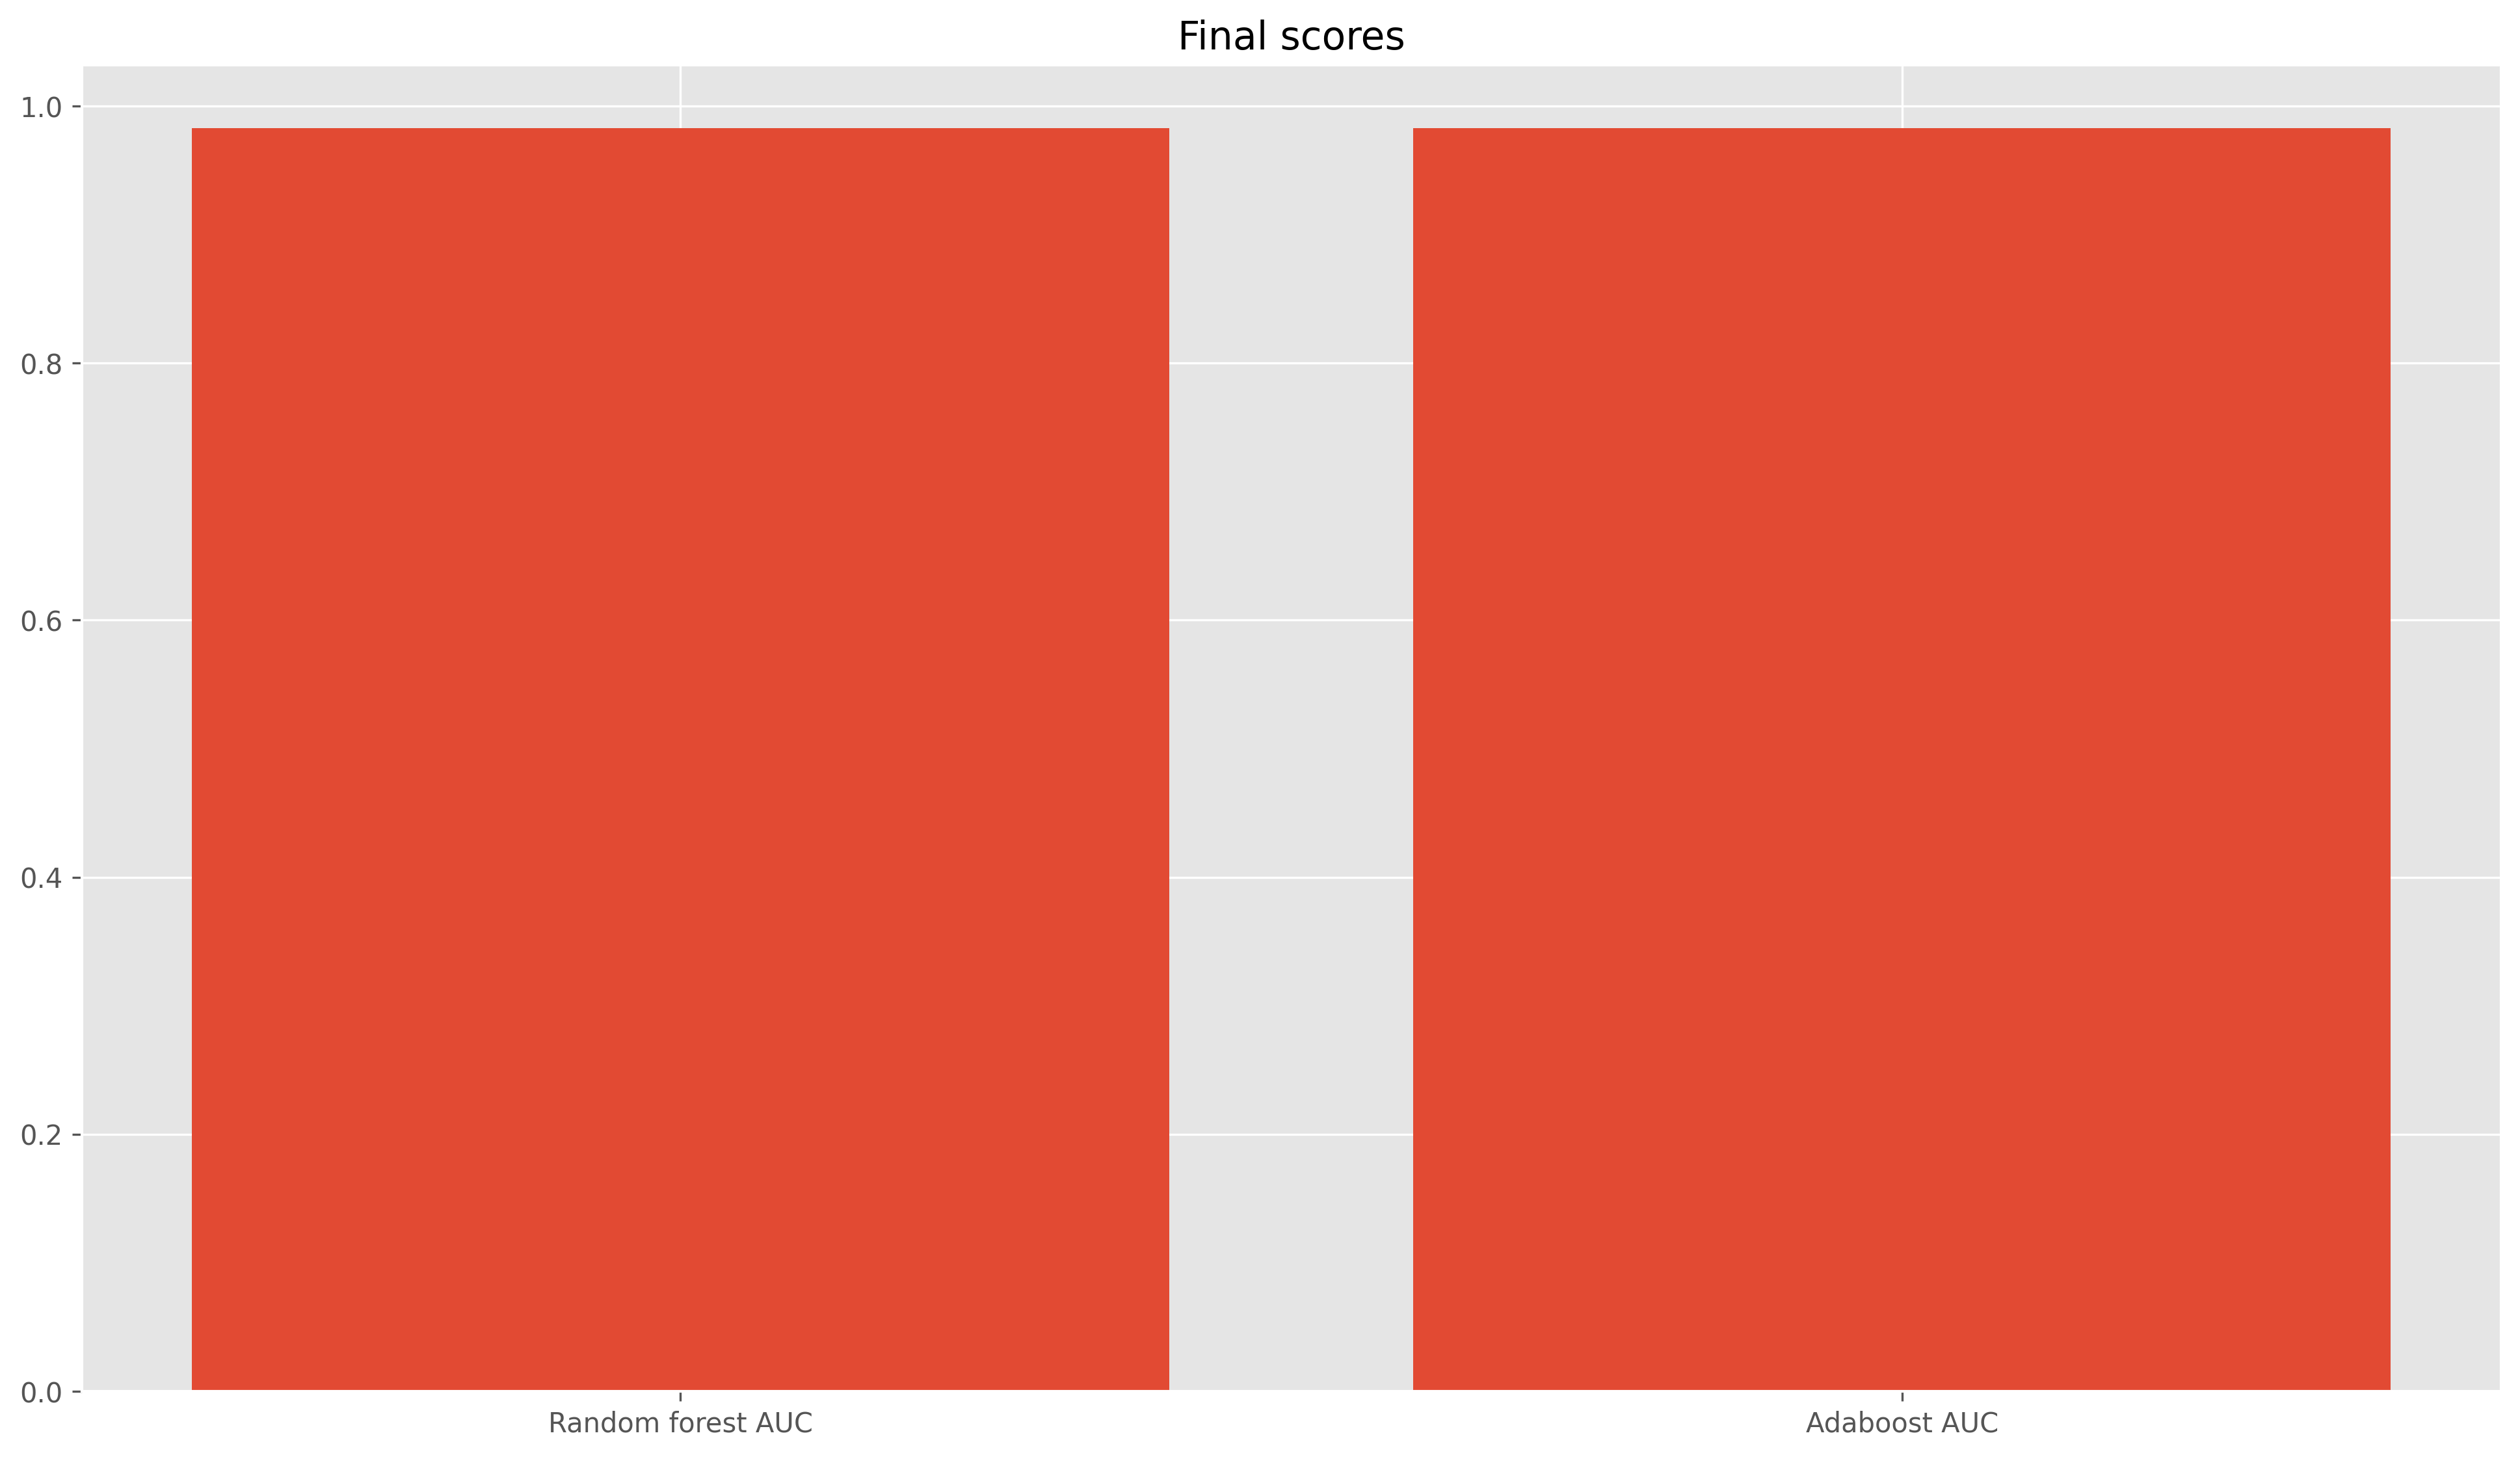

In [61]:
plt.title('Final scores')
height = [rf_auc, ada_auc]
plt.xticks(np.arange(2), ['Random forest AUC', 'Adaboost AUC'])
plt.bar(width, height)
plt.show()

#Conclusion
Both classifiers were able get good ~0.9826 roc_auc score, having good precision and recall values. 
